In [113]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as colors

# Definition of flow caracteristic

In [114]:
#List of constants
kinematic_viscosity = 1e-8 #approximate value of kinematic viscosity for CO2 in m2/s
diffusion_coefficient = 1e-9 #approximate value of diffusion coefficient for CO2 in m2/s, to check
schmidt_number = kinematic_viscosity/diffusion_coefficient

In [115]:
#Functions that returns lists of linearly spaced values for Re, L, U, T, Pr...(to complete)
def Re_list_generator(Re_min, Re_max, Re_number_of_points = 1000):
    return np.linspace(Re_min, Re_max, Re_number_of_points)

def Pr_list_generator(Pr_carac_min, Pr_carac_max, Pr_carac_number_of_points = 1000):
    return np.linspace(Pr_carac_min, Pr_carac_max, Pr_carac_number_of_points)

def L_list_generator(L_min, L_max, L_number_of_points = 1000):
    return np.linspace(L_min, L_max, L_number_of_points)

def U_list_generator(U_min, U_max, U_number_of_points = 1000):
    return np.linspace(U_min, U_max, U_number_of_points)

def T_carac_list_generator(T_carac_min, T_carac_max, T_carac_number_of_points = 1000):
    return np.linspace(T_carac_min, T_carac_max, T_carac_number_of_points)


In [116]:
#Generate here the lists for calculation, modify ranges and number of points here as desired
Re_list = Re_list_generator(Re_min = 1e0, Re_max = 1e4, Re_number_of_points = 1000)
L_list = L_list_generator(L_min = 1e-6, L_max = 1e-3, L_number_of_points = 1000) #Caracteristic length of flow  in meters
T_carac_list = T_carac_list_generator(T_carac_min = 1e-3, T_carac_max = 1e0, T_carac_number_of_points = 1000) #Caracteristic timescale of flow in seconds
U_list = U_list_generator(U_min = 1e-1, U_max = 2, U_number_of_points = 1000) #Caracteristic speed of flow in m.s-1

In [117]:
#Defines System variables with regards to previously given ones
#Re_list = U_list*L_list/kinematic_viscosity #Defines Re approximate for given range of U and L
#T_carac_list = L_list/U_list

# Kolmogorov scale approximate

## Kolmogorov length scale approximate

### Kolmogorv lengthscale approximate plot depending on Re and caracteristic lengthscale L of system

In [118]:
def calculate_approx_kolm_lengthscale_RevsL(Re_list, L_list):
    """
    Function that calculates the approximate Kolmogorov lengthscale for a given range of L and Re.
    
    Input:
    - Re_list: Array of Reynolds numbers
    - L_list: Array of characteristic length values (in meters)
    
    Output:
    - eta_array: Array of Kolmogorov lengthscale (approximate) for each pair of Re and L values (in micrometers)
    """
    # Reshape the arrays for calculation
    Re_list_reshaped = np.reshape(Re_list, (len(Re_list), 1))
    L_list_reshaped = np.reshape(L_list, (len(L_list), 1))

    # Calculate Kolmogorov lengthscale with eta ≈ L / (Re^0.75)
    Re_list_reshaped_raised_to_power = Re_list_reshaped**(-0.75)
    eta_array = L_list_reshaped @ Re_list_reshaped_raised_to_power.T
    
    # Convert to micrometers
    eta_array = eta_array * 1e6
    
    return eta_array


In [119]:
def plot_kolm_lengthscale_RevsL(Re_list, L_list, eta_array, Re_log_scale=True, L_log_scale=True, eta_log_scale=True, colormap='jet', nbr_of_contours=10):
    """
    Function that plots a colormap of the approximate Kolmogorov lengthscale for a given range of L and Re.
    
    Input:
    - Re_list: Array of Reynolds numbers
    - L_list: Array of characteristic length values (in meters)
    - eta_array: Array of Kolmogorov lengthscale values (in micrometers)
    - Re_log_scale: Boolean indicating whether to use a logarithmic scale for the Re axis (default: True)
    - L_log_scale: Boolean indicating whether to use a logarithmic scale for the L axis (default: True)
    - eta_log_scale: Boolean indicating whether to use a logarithmic scale for the eta colormap (default: True)
    - colormap: Name of the colormap (default: 'jet')
    - nbr_of_contours: Number of contour levels for the colormap (default: 10)
    """
    # Create a figure and axes
    fig, ax = plt.subplots()

    # Create the filled contour plot
    if eta_log_scale:
        fig = plt.contourf(Re_list, L_list, eta_array, levels=nbr_of_contours, cmap=colormap, norm=colors.LogNorm())
    else:
        fig = plt.contourf(Re_list, L_list, eta_array, levels=nbr_of_contours, cmap=colormap)

    # Format function for scientific notation on the axis
    def fmt(x, pos):
        a, b = '{:.2e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)
    
    if Re_log_scale:
        # Set logarithmic scale for the X axis
        ax.set_xscale('log')

    if L_log_scale:
        # Set logarithmic scale for the Y axis
        ax.set_yscale('log')

    # Add a colorbar
    cbar = plt.colorbar(fig, format=ticker.FuncFormatter(fmt))

    # Set labels for the colorbar
    cbar.ax.set_ylabel('Kolmogorov lengthscale (µm)', rotation=-90, va="bottom")

    # Add a title and labels to the axes
    ax.set_title('Approximate Kolmogorov lengthscale')
    ax.set_xlabel('Re')
    ax.set_ylabel('L (m)')

    # Show the plot
    plt.show()

In [120]:
eta_array = calculate_approx_kolm_lengthscale_RevsL(Re_list, L_list)

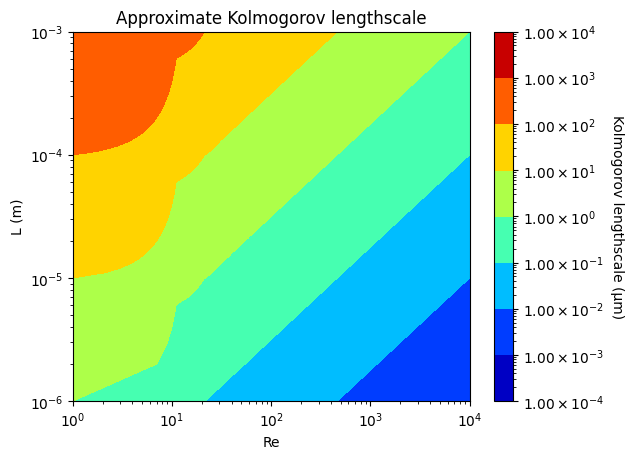

In [121]:
plot_kolm_lengthscale_RevsL(Re_list, L_list, eta_array, Re_log_scale = True, L_log_scale = True, eta_log_scale = True, colormap = 'jet', nbr_of_contours=10)

### Kolmogorv lengthscale approximate plot depending on U and caracteristic lengthscale L of system

In [122]:
def calculate_approx_kolm_lengthscale_UvsL(U_list, L_list, kinematic_viscosity):
    """
    Function that calculates the approximate Kolmogorov lengthscale for a given range of L and U.
    
    Input:
    - U_list: Array of characteristic speed values (in m/s)
    - L_list: Array of characteristic length values (in meters)
    - kinematic_viscosity: Kinematic viscosity of the fluid (in m^2/s)
    
    Output:
    - eta_array: Array of Kolmogorov lengthscale (approximate) for each pair of U and L values (in micrometers)
    """
    # Reshape the arrays for calculation
    U_list_reshaped = np.reshape(U_list, (len(U_list), 1))
    L_list_reshaped = np.reshape(L_list, (len(L_list), 1))

    # Calculate Kolmogorov lengthscale with eta ≈ (mu^3 * L / U^3)^0.25
    numerator = (kinematic_viscosity**3) * L_list_reshaped
    denominator = U_list_reshaped**-3
    eta_array = (numerator @ denominator.T) ** 0.25
    
    # Convert to micrometers
    eta_array = eta_array * 1e6
    
    return eta_array


In [123]:
eta_array = calculate_approx_kolm_lengthscale_UvsL(U_list, L_list, kinematic_viscosity)

In [124]:
def plot_kolm_lengthscale_UvsL(U_list, L_list, eta_array, U_log_scale=True, L_log_scale=True, eta_log_scale=True, colormap='jet', nbr_of_contours=10):
    """
    Function that plots a colormap of the approximate Kolmogorov lengthscale for a given range of L and U.
    
    Input:
    - U_list: Array of characteristic speed values (in m/s)
    - L_list: Array of characteristic length values (in meters)
    - eta_array: Array of Kolmogorov lengthscale values (in micrometers)
    - U_log_scale: Boolean indicating whether to use a logarithmic scale for the U axis (default: True)
    - L_log_scale: Boolean indicating whether to use a logarithmic scale for the L axis (default: True)
    - eta_log_scale: Boolean indicating whether to use a logarithmic scale for the eta colormap (default: True)
    - colormap: Name of the colormap (default: 'jet')
    - nbr_of_contours: Number of contour levels for the colormap (default: 10)
    """
    # Create a figure and axes
    fig, ax = plt.subplots()

    # Create the filled contour plot
    if eta_log_scale:
        fig = plt.contourf(U_list, L_list, eta_array, levels=nbr_of_contours, cmap=colormap, norm=colors.LogNorm())
    else:
        fig = plt.contourf(U_list, L_list, eta_array, levels=nbr_of_contours, cmap=colormap)

    # Format function for scientific notation on the axis
    def fmt(x, pos):
        a, b = '{:.2e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)
    
    if U_log_scale:
        # Set logarithmic scale for the X axis
        ax.set_xscale('log')

    if L_log_scale:
        # Set logarithmic scale for the Y axis
        ax.set_yscale('log')

    # Add a colorbar
    cbar = plt.colorbar(fig, format=ticker.FuncFormatter(fmt))

    # Set labels for the colorbar
    cbar.ax.set_ylabel('Kolmogorov lengthscale (µm)', rotation=-90, va="bottom")

    # Add a title and labels to the axes
    ax.set_title('Approximate Kolmogorov lengthscale')
    ax.set_xlabel('U (m/s)')
    ax.set_ylabel('L (m)')

    # Show the plot
    plt.show()


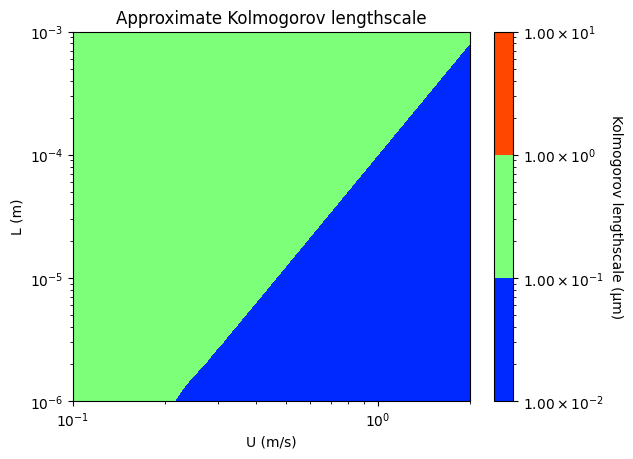

In [125]:
plot_kolm_lengthscale_UvsL(U_list, L_list, eta_array, U_log_scale = True, L_log_scale = True, eta_log_scale = True, colormap = 'jet', nbr_of_contours=10)

## Kolmogorv timescale approximate

### Kolmogorv timescale approximate plot depending on Re and caracteristic timescale T of system

In [126]:
def calculate_approx_kolm_timescale_RevsT_carac(Re_list, T_carac_list):
    """
    Function that calculates the approximate Kolmogorov timescale for a given range of T_carac and Re.
    
    Input:
    - Re_list: Array of Reynolds numbers
    - T_carac_list: Array of characteristic time values (in seconds)
    
    Output:
    - t_eta_array: Array of Kolmogorov timescale (approximate) for each pair of Re and L values (in seconds)
    """
    # Reshape the arrays for calculation
    Re_list_reshaped = np.reshape(Re_list, (len(Re_list), 1))
    T_carac_list_reshaped = np.reshape(T_carac_list, (len(T_carac_list), 1))

    # Calculate Kolmogorov timescale with t_eta =~ T_carac/(Re^0.5)
    Re_list_reshaped_raised_to_power = Re_list_reshaped**(-0.5)
    t_eta_array = T_carac_list_reshaped @ Re_list_reshaped_raised_to_power.T
    
    return t_eta_array

In [127]:
t_eta_array = calculate_approx_kolm_timescale_RevsT_carac(Re_list, T_carac_list)

In [128]:
def plot_kolm_timescale(Re_list, T_carac_list, t_eta_array, Re_log_scale=True, T_carac_log_scale=True, t_eta_log_scale=True, colormap='jet', nbr_of_countours=10):
    """
    Function that plots a colormap of the approximate Kolmogorov timescale for a given range of T_carac and Re.

    Inputs:
    - Re_list: List of Reynolds numbers
    - T_carac_list: List of characteristic times (in seconds)
    - t_eta_array: Array of Kolmogorov timescale values (in seconds)
    - Re_log_scale: Boolean indicating whether to use a logarithmic scale for the X axis (Re). Default is True.
    - T_carac_log_scale: Boolean indicating whether to use a logarithmic scale for the Y axis (T_carac). Default is True.
    - t_eta_log_scale: Boolean indicating whether to use a logarithmic scale for the colormap of t_eta. Default is True.
    - colormap: Colormap to use for the filled contour plot. Default is 'jet'.
    - nbr_of_countours: Number of contours to plot. Default is 10.

    Output:
    - Countour map of t_eta, i.e., the approximate Kolmogorov timescale.
    """

    # Create a figure and axes
    fig, ax = plt.subplots()

    # Create the filled contour plot
    if t_eta_log_scale:
        fig = plt.contourf(Re_list, T_carac_list, t_eta_array, levels=nbr_of_countours, cmap=colormap, norm=colors.LogNorm())
    else:
        fig = plt.contourf(Re_list, T_carac_list, t_eta_array, levels=nbr_of_countours, cmap=colormap)

    # Format function for scientific notation on axis
    def fmt(x, pos):
        a, b = '{:.2e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)

    if Re_log_scale:
        # Set logarithmic scale for the X axis
        ax.set_xscale('log')

    if T_carac_log_scale:
        # Set logarithmic scale for the Y axis
        ax.set_yscale('log')

    # Add a colorbar
    cbar = plt.colorbar(fig, format=ticker.FuncFormatter(fmt))

    # Set labels for the colorbar
    cbar.ax.set_ylabel('Kolmogorov timescale (s)', rotation=-90, va="bottom")

    # Add a title and labels to the axes
    ax.set_title('Approximate Kolmogorov timescale')
    ax.set_xlabel('Re')
    ax.set_ylabel('T_carac (s)')

    # Show the plot
    plt.show()


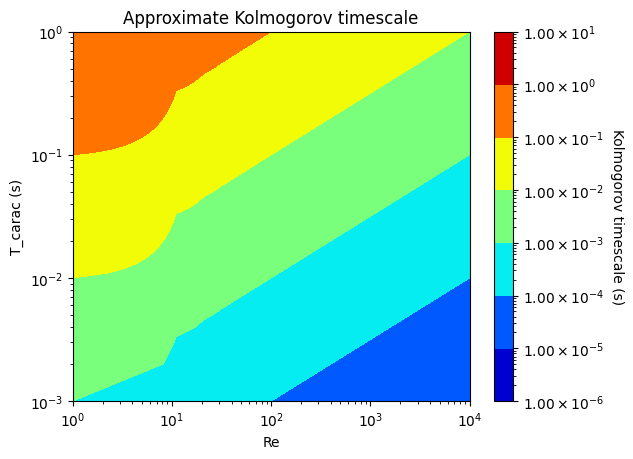

In [129]:
plot_kolm_timescale(Re_list, T_carac_list, t_eta_array, Re_log_scale = True, T_carac_log_scale = True, t_eta_log_scale = True, colormap = 'jet', nbr_of_countours = 10)

### Kolmogorv timescale approximate plot depending on U and L

In [130]:
def calculate_approx_kolm_timescale_UvsL(U_list, L_list, kinematic_viscosity):
    """
    Function that calculates the approximate Kolmogorov timescale for a given range of L and U.

    Input:
    - U_list: Array of characteristic speed values (in m/s)
    - L_list: Array of characteristic length values (in meters)
    - kinematic_viscosity: Kinematic viscosity of the fluid (in m^2/s)

    Output:
    - t_eta_array: Array of Kolmogorov timescale values (in seconds) for each pair of U and L values in the given range
    """
    # Create the data to calculate
    U_list_reshaped = np.reshape(U_list, (np.size(U_list), 1))
    L_list_reshaped = np.reshape(L_list, (np.size(L_list), 1))

    # Calculate Kolmogorov timescale with t_eta =~ (L * mu / U^3)^0.5
    numerator = kinematic_viscosity * L_list_reshaped
    denominator = U_list_reshaped ** -3
    t_eta_array = (numerator @ denominator.T) ** 0.5

    return t_eta_array


In [131]:
t_eta_array = calculate_approx_kolm_timescale_UvsL(U_list, L_list, kinematic_viscosity)

In [132]:
def plot_kolm_timescale_UvsL(U_list, L_list, t_eta_array, U_log_scale=True, L_log_scale=True, t_eta_log_scale=True, colormap='jet', nbr_of_contours=10):
    """
    Function that plots a colormap of the approximate Kolmogorov timescale for a given range of L and U.

    Input:
    - U_list: Array of characteristic speed values (in m/s)
    - L_list: Array of characteristic length values (in meters)
    - t_eta_array: Array of Kolmogorov timescale values (in seconds) for each pair of U and L values
    - U_log_scale: Boolean flag indicating whether to use a logarithmic scale for the X axis (default: True)
    - L_log_scale: Boolean flag indicating whether to use a logarithmic scale for the Y axis (default: True)
    - t_eta_log_scale: Boolean flag indicating whether to use a logarithmic scale for the colormap (default: True)
    - colormap: Name of the colormap to use (default: 'jet')
    - nbr_of_countours: Number of contour levels for the colormap (default: 10)
    """
    # Create a figure and axes
    fig, ax = plt.subplots()

    # Create the filled contour plot
    if t_eta_log_scale:
        fig = plt.contourf(U_list, L_list, t_eta_array, levels=nbr_of_contours, cmap=colormap, norm=colors.LogNorm())
    else:
        fig = plt.contourf(U_list, L_list, t_eta_array, levels=nbr_of_contours, cmap=colormap)

    # Format func for scientific notation on axis
    def fmt(x, pos):
        a, b = '{:.2e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)

    if U_log_scale:
        # Set logarithmic scale for the X axis
        ax.set_xscale('log')

    if L_log_scale:
        # Set logarithmic scale for the Y axis
        ax.set_yscale('log')

    # Add a colorbar
    cbar = plt.colorbar(fig, format=ticker.FuncFormatter(fmt))

    # Set labels for the colorbar
    cbar.ax.set_ylabel('Kolmogorov timescale (s)', rotation=-90, va="bottom")

    # Add a title and labels to the axes
    ax.set_title('Approximate Kolmogorov timescale')
    ax.set_xlabel('U (m/s)')
    ax.set_ylabel('L (m)')

    # Show the plot
    plt.show()


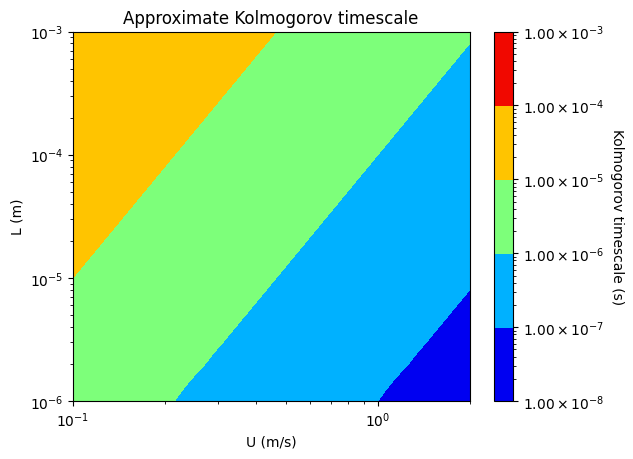

In [133]:
plot_kolm_timescale_UvsL(U_list, L_list, t_eta_array, U_log_scale = True, L_log_scale = True, t_eta_log_scale = True, colormap = 'jet', nbr_of_contours = 10)


# Taylor scale approximate

## Taylor length scale approximate

### Taylor lengthscale approximate plot depending on U and L

In [134]:
def calculate_approx_taylor_lengthscale_UvsL(U_list, L_list, kinematic_viscosity):
    """
    Function that calculates the approximate Taylor lengthscale for a given range of L and U.

    Input:
    - U_list: Array of characteristic speed values (in m/s)
    - L_list: Array of characteristic length values (in meters)
    - kinematic_viscosity: Kinematic viscosity (in m^2/s)

    Output:
    - lambda_array: Array of Taylor lengthscale values (in micrometers) for each pair of U and L values

    Formula: lambda =~ (10 * L * mu / U)^0.5
    """

    # Reshape the arrays to Nx1 arrays for matrix multiplication
    U_list_reshaped = np.reshape(U_list, (np.size(U_list), 1))
    L_list_reshaped = np.reshape(L_list, (np.size(L_list), 1))

    # Calculate Taylor lengthscale
    numerator = 10 * L_list_reshaped * kinematic_viscosity
    denominator = U_list_reshaped ** -1
    lambda_array = (numerator @ denominator.T) ** 0.5  # Values of Taylor lengthscale (Approximate) in meter
    lambda_array = lambda_array * 1e6  # Conversion to micrometers

    return lambda_array


In [135]:
lambda_array = calculate_approx_taylor_lengthscale_UvsL(U_list, L_list, kinematic_viscosity)

In [136]:
def plot_taylor_lengthscale_UvsL(U_list, L_list, lambda_array, U_log_scale=True, L_log_scale=True, lambda_array_log_scale=True, colormap='jet', nbr_of_contours=10):
    """
    Function that plots a colormap of the approximate Taylor lengthscale for a given range of L and U.

    Input:
    - U_list: Array of characteristic speed values (in m/s)
    - L_list: Array of characteristic length values (in meters)
    - lambda_array: Array of Taylor lengthscale values (in micrometers) for each pair of U and L values
    - U_log_scale: Boolean flag indicating whether to use a logarithmic scale for the X axis (default: True)
    - L_log_scale: Boolean flag indicating whether to use a logarithmic scale for the Y axis (default: True)
    - lambda_array_log_scale: Boolean flag indicating whether to use a logarithmic scale for the colormap (default: True)
    - colormap: Name of the colormap to use (default: 'jet')
    - nbr_of_countours: Number of contour levels for the colormap (default: 10)
    """
    # Create a figure and axes
    fig, ax = plt.subplots()

    # Create the filled contour plot
    if lambda_array_log_scale:
        fig = plt.contourf(U_list, L_list, lambda_array, levels=nbr_of_contours, cmap=colormap, norm=colors.LogNorm())
    else:
        fig = plt.contourf(U_list, L_list, lambda_array, levels=nbr_of_contours, cmap=colormap)

    # Format func for scientific notation on axis
    def fmt(x, pos):
        a, b = '{:.2e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)

    if U_log_scale:
        # Set logarithmic scale for the X axis
        ax.set_xscale('log')

    if L_log_scale:
        # Set logarithmic scale for the Y axis
        ax.set_yscale('log')

    # Add a colorbar
    cbar = plt.colorbar(fig, format=ticker.FuncFormatter(fmt))

    # Set labels for the colorbar
    cbar.ax.set_ylabel('Taylor lengthscale (µm)', rotation=-90, va="bottom")

    # Add a title and labels to the axes
    ax.set_title('Approximate Taylor lengthscale')
    ax.set_xlabel('U (m/s)')
    ax.set_ylabel('L (m)')

    # Show the plot
    plt.show()


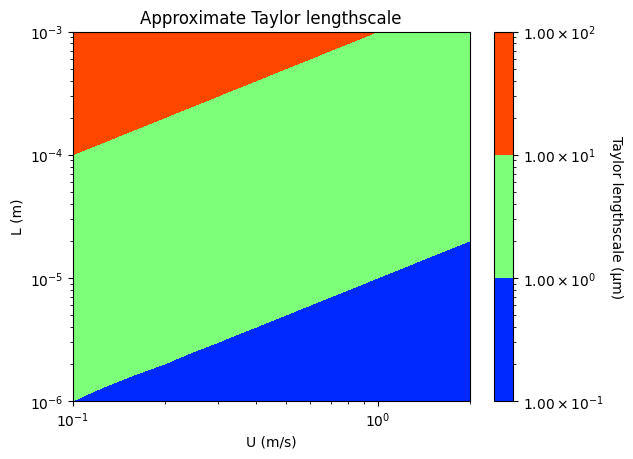

In [137]:
plot_taylor_lengthscale_UvsL(U_list, L_list, lambda_array, U_log_scale=True, L_log_scale=True, lambda_array_log_scale=True, colormap='jet', nbr_of_contours=10)


## Taylor time scale approximate

### Taylor timescale approximate plot depending on U and L

In [138]:
def calculate_approx_taylor_timescale_UvsL(U_list, L_list, kinematic_viscosity):
    """
    Function that calculates the approximate Taylor timescale for a given range of L and U.

    Input:
    - U_list: Array of characteristic speed values (in m/s)
    - L_list: Array of characteristic length values (in meters)
    - kinematic_viscosity: Kinematic viscosity (in m^2/s)

    Output:
    - t_lambda_array: Array of Taylor timescale values (in seconds) for each pair of U and L values

    Formula: t_lambda_array =~ (15 * L * mu / U^3)^0.5
    """

    # Reshape the arrays to Nx1 arrays for matrix multiplication
    U_list_reshaped = np.reshape(U_list, (np.size(U_list), 1))
    L_list_reshaped = np.reshape(L_list, (np.size(L_list), 1))

    # Calculate Taylor timescale
    numerator = 15 * L_list_reshaped * kinematic_viscosity
    denominator = U_list_reshaped ** -3
    t_lambda_array = (numerator @ denominator.T) ** 0.5  # Values of Taylor timescale (Approximate) in seconds

    return t_lambda_array


In [139]:
t_lambda_array = calculate_approx_taylor_timescale_UvsL(U_list, L_list, kinematic_viscosity)


In [140]:
def plot_taylor_timescale_UvsL(U_list, L_list, t_lambda_array, U_log_scale=True, L_log_scale=True, t_lambda_array_log_scale=True, colormap='jet', nbr_of_contours=10):
    """
    Function that plots a colormap of the approximate Taylor timescale for a given range of L and U.

    Input:
    - U_list: Array of characteristic speed values (in m/s)
    - L_list: Array of characteristic length values (in meters)
    - t_lambda_array: Array of Taylor timescale values (in seconds) for each pair of U and L values
    - U_log_scale: Boolean flag indicating whether to use a logarithmic scale for the X axis (default: True)
    - L_log_scale: Boolean flag indicating whether to use a logarithmic scale for the Y axis (default: True)
    - t_lambda_array_log_scale: Boolean flag indicating whether to use a logarithmic scale for the colormap (default: True)
    - colormap: Name of the colormap to use (default: 'jet')
    - nbr_of_countours: Number of contour levels for the colormap (default: 10)
    """
    # Create a figure and axes
    fig, ax = plt.subplots()

    # Create the filled contour plot
    if t_lambda_array_log_scale:
        fig = plt.contourf(U_list, L_list, t_lambda_array, levels=nbr_of_contours, cmap=colormap, norm=colors.LogNorm())
    else:
        fig = plt.contourf(U_list, L_list, t_lambda_array, levels=nbr_of_contours, cmap=colormap)

    # Format func for scientific notation on axis
    def fmt(x, pos):
        a, b = '{:.2e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)

    if U_log_scale:
        # Set logarithmic scale for the X axis
        ax.set_xscale('log')

    if L_log_scale:
        # Set logarithmic scale for the Y axis
        ax.set_yscale('log')

    # Add a colorbar
    cbar = plt.colorbar(fig, format=ticker.FuncFormatter(fmt))

    # Set labels for the colorbar
    cbar.ax.set_ylabel('Taylor timescale (s)', rotation=-90, va="bottom")

    # Add a title and labels to the axes
    ax.set_title('Approximate Taylor timescale')
    ax.set_xlabel('U (m/s)')
    ax.set_ylabel('L (m)')

    # Show the plot
    plt.show()


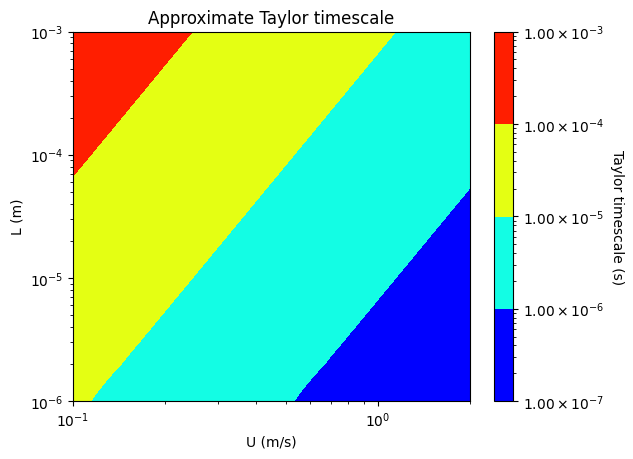

In [141]:
plot_taylor_timescale_UvsL(U_list, L_list, t_lambda_array, U_log_scale=True, L_log_scale=True, t_lambda_array_log_scale=True, colormap='jet', nbr_of_contours=10)


# Batchelor scale approximate

## Batchelor lenghtscale approximate

### Batchelor lenghtscale approximate plot depending on U and L

In [142]:
# Formula: batchelor_lengthscale = kolmogorov_lengthscale/sqrt(Sc), see ref on wikipedia Batchelor scale

lambda_batchelor_array = eta_array/np.sqrt(schmidt_number)

In [143]:
def plot_batchelor_lenghtscale_UvsL(U_list, L_list, lambda_batchelor_array, U_log_scale=True, L_log_scale=True, lambda_batchelor_log_scale=True, colormap='jet', nbr_of_contours=10):
    """
    Function that plots a colormap of the approximate Batchelor lenghtscale for a given range of L and U.

    Input:
    - U_list: Array of characteristic speed values (in m/s)
    - L_list: Array of characteristic length values (in meters)
    - lambda_batchelor_array: Array of Batchelor lenghtscale values (in micro meters) for each pair of U and L values
    - U_log_scale: Boolean flag indicating whether to use a logarithmic scale for the X axis (default: True)
    - L_log_scale: Boolean flag indicating whether to use a logarithmic scale for the Y axis (default: True)
    - lambda_batchelor_log_scale: Boolean flag indicating whether to use a logarithmic scale for the colormap (default: True)
    - colormap: Name of the colormap to use (default: 'jet')
    - nbr_of_countours: Number of contour levels for the colormap (default: 10)
    """
    # Create a figure and axes
    fig, ax = plt.subplots()

    # Create the filled contour plot
    if lambda_batchelor_log_scale:
        fig = plt.contourf(U_list, L_list, lambda_batchelor_array, levels=nbr_of_contours, cmap=colormap, norm=colors.LogNorm())
    else:
        fig = plt.contourf(U_list, L_list, lambda_batchelor_array, levels=nbr_of_contours, cmap=colormap)

    # Format func for scientific notation on axis
    def fmt(x, pos):
        a, b = '{:.2e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)

    if U_log_scale:
        # Set logarithmic scale for the X axis
        ax.set_xscale('log')

    if L_log_scale:
        # Set logarithmic scale for the Y axis
        ax.set_yscale('log')

    # Add a colorbar
    cbar = plt.colorbar(fig, format=ticker.FuncFormatter(fmt))

    # Set labels for the colorbar
    cbar.ax.set_ylabel('Batchelor lenghtscale (µm)', rotation=-90, va="bottom")

    # Add a title and labels to the axes
    ax.set_title('Approximate Batchelor lenghtscale')
    ax.set_xlabel('U (m/s)')
    ax.set_ylabel('L (m)')

    # Show the plot
    plt.show()


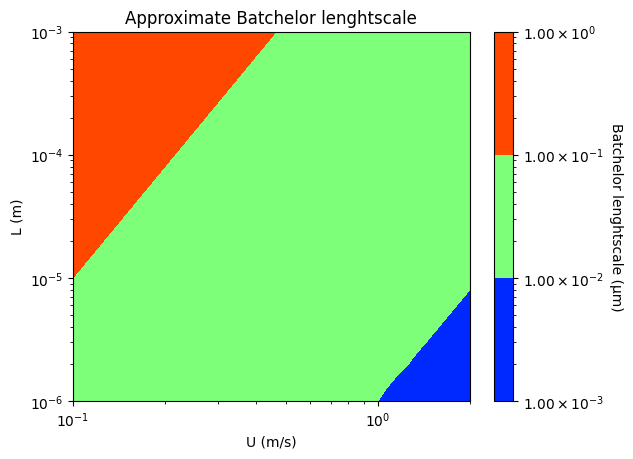

In [144]:
plot_batchelor_lenghtscale_UvsL(U_list, L_list, lambda_batchelor_array, U_log_scale=True, L_log_scale=True, lambda_batchelor_log_scale=True, colormap='jet', nbr_of_contours=10)


### Batchelor timescale approximate plot depending on U and L

In [145]:
## ???? Can i define a Batchelor timescale ?

# Integral scale approximate

Is it relevant ?? In the sense that I used l_integral ~ L in the previous calculation and that we should at least expect to see this scale of turbulence with our sensors

# Time vs spatial resolution

In [156]:
L = 1e-6 #in meters, To specify
U = 1e0 # in m/s, To specify
T = 1e-6 #in seconds

turbulent_timescales_values = [1e-8, 1e-7, 1e-6] #List of turbulent approximate timescales values for given L and U values (integral, Taylor, Batchelor, Kolmogorov... see Pope's turbulence book for ref), in seconds
turbulent_lengthscales_values = [1e-9, 1e-8, 1e-7, 1e-6] #List of turbulent approximate lengthscales values for given L and U values (integral, Taylor, Batchelor, Kolmogorov... see Pope's turbulence book for ref), in meters

turbulent_timescales_labels = ['Kolm','Taylor','Int'] #List of turbulent timescales labels for each numerical value
turbulent_lengthscales_labels = ['Kolm','Batch','Taylor','Int'] #List of turbulent lengthscale labels for each numerical value


sensor_labels = ['sensor_type_1', 'sensor_type_2'] #List of the different sensor tech names
spatial_resolutions = [1e-7,1e-8] #List of the different sensor techs approxiamte spatial resolution limits in meters
temporal_resolutions = [1e-8,1e-7] #List of the different sensor techs approxiamte temporal resolution limits in seconds

color_list = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']

#Max values
T = max(turbulent_timescales_values)
L = max(turbulent_lengthscales_values)

#Min values
min_l = min(turbulent_lengthscales_values)
min_t = min(turbulent_timescales_values)



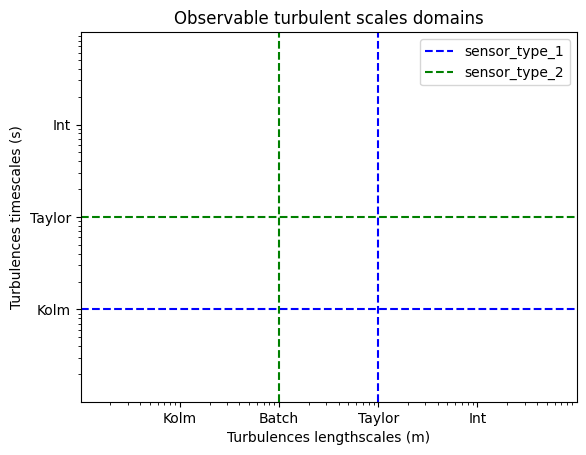

In [166]:
# Create Figure and Axes objects
fig, ax = plt.subplots()

# Set labels for X and Y axes
ax.set_xlabel('Turbulences lengthscales (m)')
ax.set_ylabel('Turbulences timescales (s)') 

# Set the limits for X and Y axes
ax.set_xlim(min_l/10, L*10)  # X-axis limits from 0 to 6
ax.set_ylim(min_t/10, T*10)  # Y-axis limits from 0 to 12


# Add vertical and horizontal lines corresponding to sensors spatiotemporal resolutions
for index, label in enumerate(sensor_labels):
    ax.axvline(x=spatial_resolutions[index], color=color_list[index], linestyle='--', label=label)  # Vertical line at x=spatial_resolutions[index]
    ax.axhline(y=temporal_resolutions[index], color=color_list[index], linestyle='--')  # Horizontal line at y=temporal_resolutions[index]
    
    # Add a horizontal span between y=2 and y=4
    plt.axhspan(2, 4, color='gray', alpha=0.3)

    # Add a vertical span between x=2 and x=4
    plt.axvspan(2, 4, color='green', alpha=0.3)



#Set axis scale to log
ax.set_xscale('log')
ax.set_yscale('log')

# Set custom tick positions and labels for the X-axis
xticks = turbulent_lengthscales_values
xtick_labels = turbulent_lengthscales_labels
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)

# Set custom tick positions and labels for the Y-axis
yticks = turbulent_timescales_values
ytick_labels = turbulent_timescales_labels
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels)



# Add a legend
ax.legend()

# Set title for the plot
ax.set_title('Observable turbulent scales domains')

# Display the empty plot
plt.show()


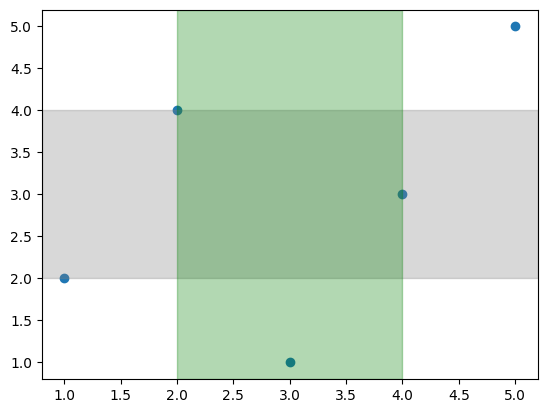

In [167]:
import matplotlib.pyplot as plt

# Create a simple scatter plot
x = [1, 2, 3, 4, 5]
y = [2, 4, 1, 3, 5]
plt.scatter(x, y)

# Add a horizontal span between y=2 and y=4
plt.axhspan(2, 4, color='gray', alpha=0.3)

# Add a vertical span between x=2 and x=4
plt.axvspan(2, 4, color='green', alpha=0.3)

# Display the plot
plt.show()
